In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.stats import t

In [21]:
#Read Data
df = pd.read_csv("/content/final_data3.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Height          315 non-null    int64  
 1   Standing_Reach  315 non-null    int64  
 2   Weight          315 non-null    int64  
 3   Age             315 non-null    int64  
 4   Dunk            315 non-null    int64  
 5   Age_First_Dunk  315 non-null    int64  
 6   Max_Vert        315 non-null    int64  
 7   Standing_Vert   315 non-null    int64  
 8   Back_Squat      315 non-null    int64  
 9   Front_Squat     315 non-null    int64  
 10  Deadlift        315 non-null    int64  
 11  Power_Clean     315 non-null    int64  
 12  THP             315 non-null    int64  
 13  bs_bw           315 non-null    float64
 14  fs_bw           315 non-null    float64
 15  pc_bw           315 non-null    float64
 16  dl_bw           315 non-null    float64
dtypes: float64(4), int64(13)
memory usa

# Vertical Jump Distribution by Age

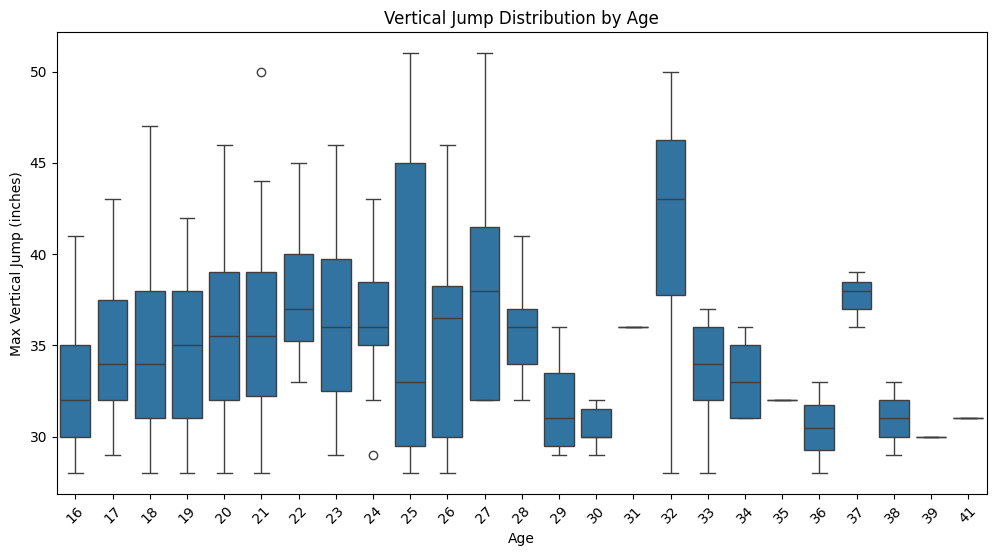

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Age'], y=df['Max_Vert'])
plt.xlabel("Age")
plt.ylabel("Max Vertical Jump (inches)")
plt.title("Vertical Jump Distribution by Age")
plt.xticks(rotation=45)
plt.show()

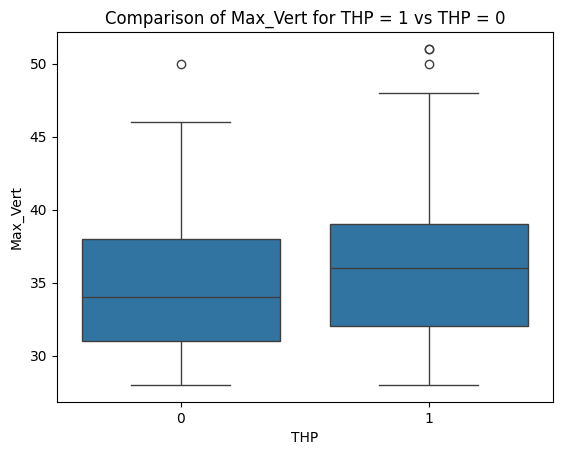

In [24]:
# Boxplot
sns.boxplot(x="THP", y="Max_Vert", data=df)
plt.title("Comparison of Max_Vert for THP = 1 vs THP = 0")
plt.show()

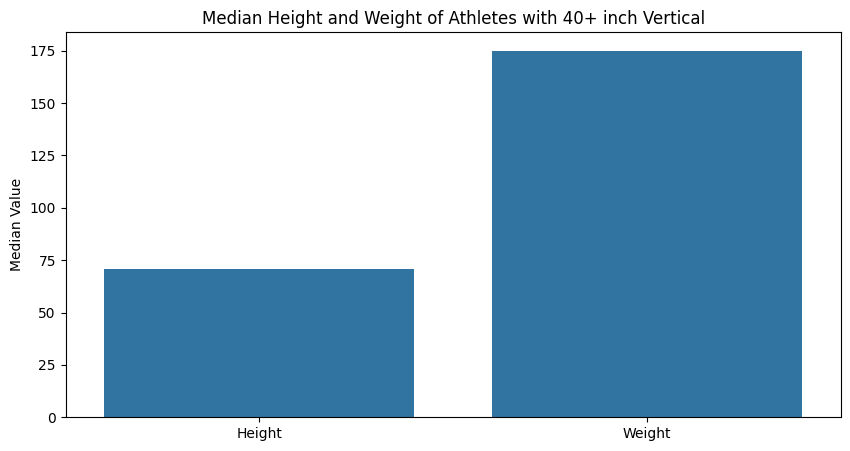

In [25]:
# Graph: Median Height and Weight of Athletes with 40+ inch Vertical
athletes_40_vert = df[df['Max_Vert'] > 40]
plt.figure(figsize=(10, 5))
sns.barplot(x=["Height", "Weight"], y=[athletes_40_vert["Height"].median(), athletes_40_vert["Weight"].median()])
plt.ylabel("Median Value")
plt.title("Median Height and Weight of Athletes with 40+ inch Vertical")
plt.show()

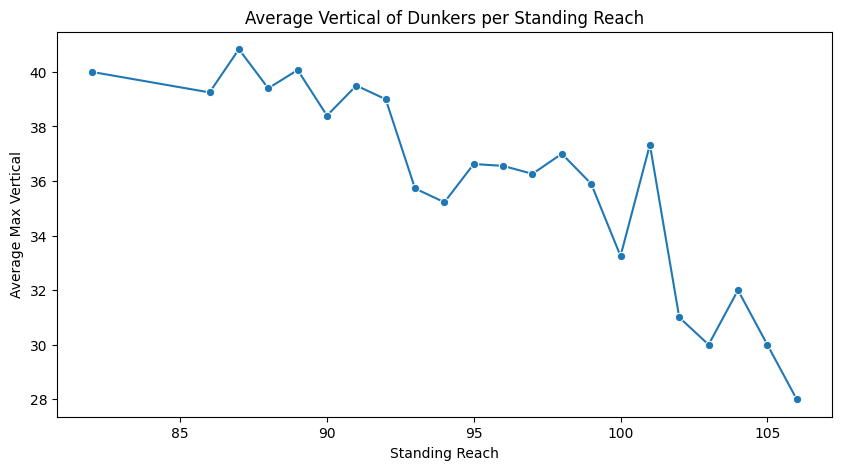

In [26]:
# Graph: Average Vertical of People Who Can Dunk per Standing Reach
dunkers = df[df['Dunk'] == 1]
standing_reach_avg_vert = dunkers.groupby("Standing_Reach")["Max_Vert"].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x="Standing_Reach", y="Max_Vert", data=standing_reach_avg_vert, marker="o")
plt.xlabel("Standing Reach")
plt.ylabel("Average Max Vertical")
plt.title("Average Vertical of Dunkers per Standing Reach")
plt.show()

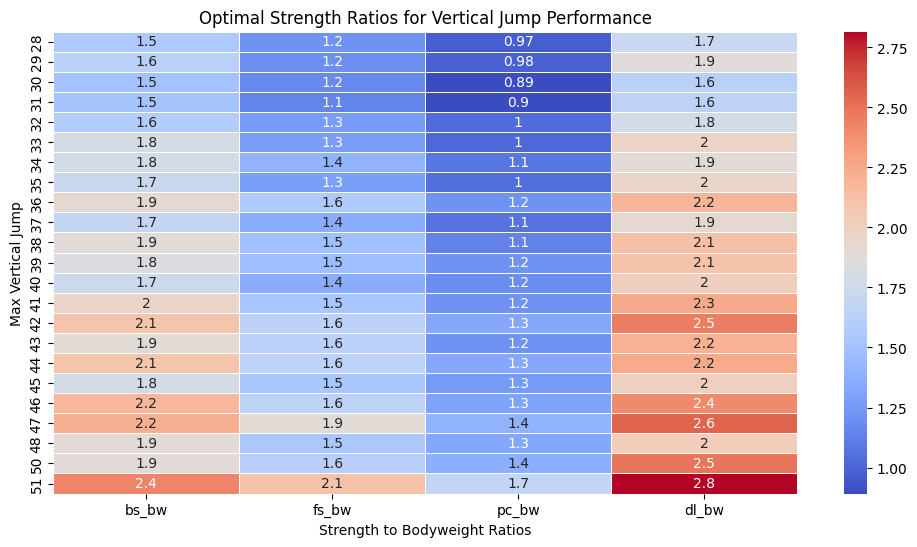

In [57]:
# Table: Optimal Strength Ratios vs. Vertical Jump
optimal_ratios = df.groupby("Max_Vert")[["bs_bw", "fs_bw", "pc_bw", "dl_bw"]].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.heatmap(optimal_ratios.set_index("Max_Vert"), annot=True, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Strength to Bodyweight Ratios")
plt.ylabel("Max Vertical Jump")
plt.title("Optimal Strength Ratios for Vertical Jump Performance")
plt.show()


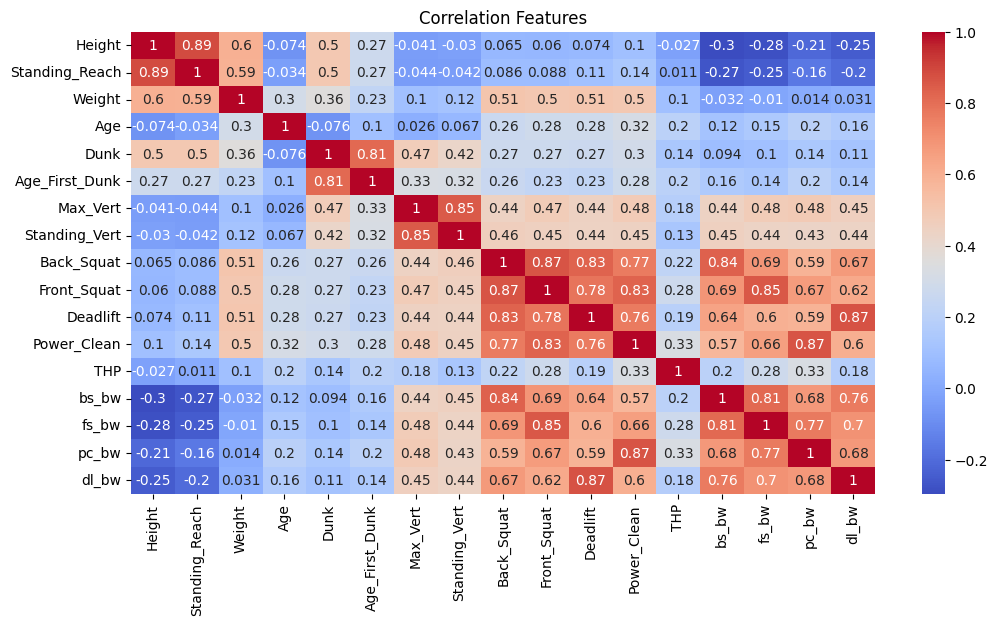

In [27]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Features')
plt.show()

# Training DF

In [28]:
features = ['Back_Squat', 'Front_Squat', 'Deadlift', 'Power_Clean', 'THP', 'bs_bw', 'fs_bw', 'pc_bw', 'dl_bw', 'Weight', 'Standing_Reach', 'Age']
target = 'Max_Vert'

X = df[features]
y = df[target]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [31]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [32]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")
    print("-" * 40)

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")

Model: Linear Regression
Mean Absolute Error (MAE): 2.95
Mean Squared Error (MSE): 14.54
Root Mean Squared Error (RMSE): 3.81
R² Score: 0.42
----------------------------------------
Model: Random Forest
Mean Absolute Error (MAE): 3.10
Mean Squared Error (MSE): 15.10
Root Mean Squared Error (RMSE): 3.89
R² Score: 0.40
----------------------------------------


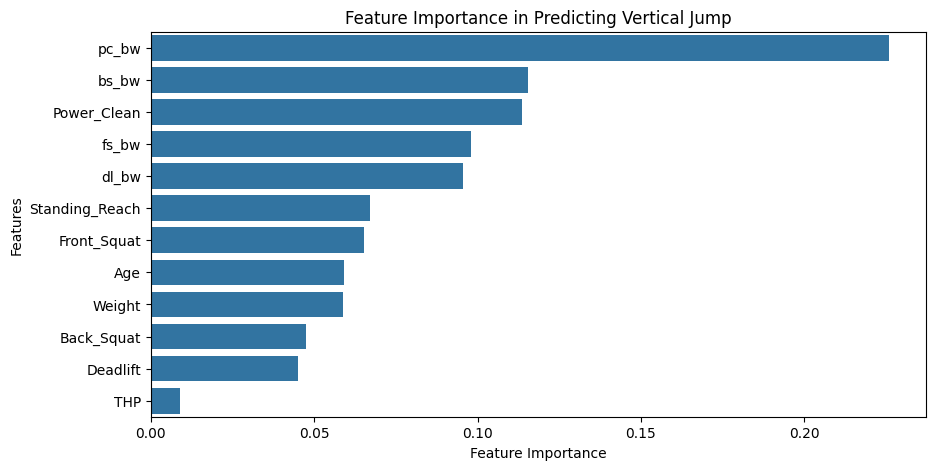

In [33]:
feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Vertical Jump")
plt.show()

Your Power Clean to Body weight ratio is the most important weightroom trait when it comes to weight training and vertical jump.

Power Clean is looked at to be the best weightroom exercise to improve vert

# New Data Frame Created

In [34]:
#Drop unwanted columns
drop_cols = ["Height", "Standing_Reach", "Weight", "Back_Squat", "Front_Squat", "Power_Clean", "Deadlift"]
df1 = df.drop(columns=drop_cols)

In [35]:
#New Feature Creation
df1["HxSR"] = df["Height"] * df["Standing_Reach"]

# Linear Regression

In [36]:
X = sm.add_constant(df1["THP"])  # Adding constant for intercept
y = df1["Max_Vert"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Max_Vert   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     11.07
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000982
Time:                        14:20:05   Log-Likelihood:                -928.51
No. Observations:                 315   AIC:                             1861.
Df Residuals:                     313   BIC:                             1869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.3602      0.339    101.279      0.0

In [37]:
# Correlation Matrix
corr_matrix = df1.corr()
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                     Age      Dunk  Age_First_Dunk  Max_Vert  Standing_Vert  \
Age             1.000000 -0.076132        0.102504  0.026158       0.067021   
Dunk           -0.076132  1.000000        0.814196  0.472468       0.418887   
Age_First_Dunk  0.102504  0.814196        1.000000  0.331670       0.324753   
Max_Vert        0.026158  0.472468        0.331670  1.000000       0.849535   
Standing_Vert   0.067021  0.418887        0.324753  0.849535       1.000000   
THP             0.203449  0.136806        0.200950  0.184815       0.132097   
bs_bw           0.117274  0.093503        0.156310  0.439085       0.451611   
fs_bw           0.145269  0.100689        0.135003  0.477033       0.437190   
pc_bw           0.196187  0.141895        0.201674  0.484780       0.432986   
dl_bw           0.160347  0.114837        0.144976  0.454036       0.437571   
HxSR           -0.053987  0.510695        0.276802 -0.046384      -0.041676   

                     THP     bs

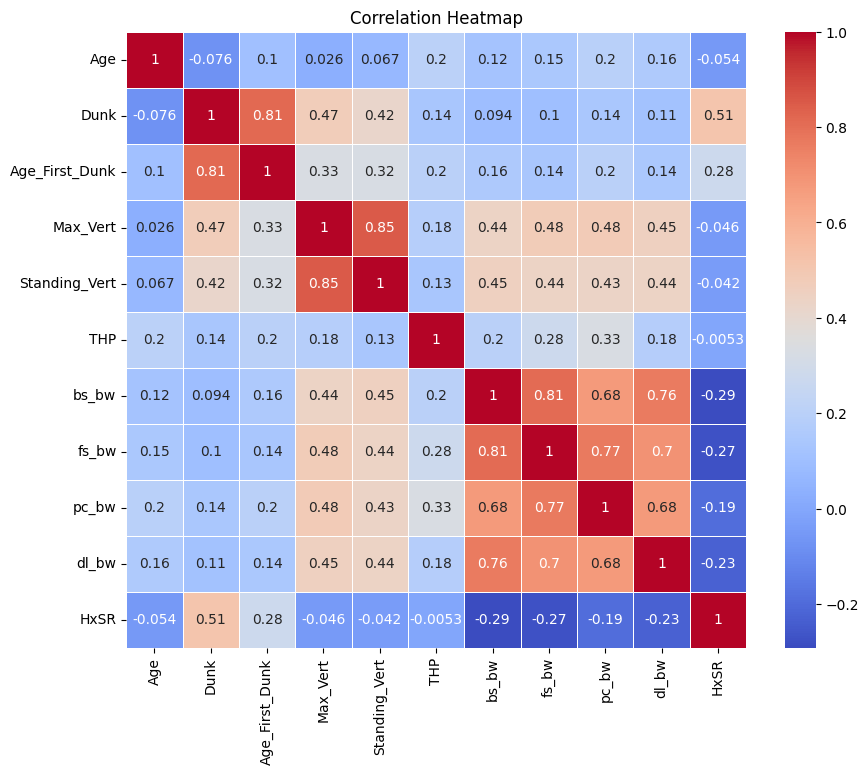

In [38]:
# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [39]:
# Standardizing features
scaler = StandardScaler()
df_scaled = df1.copy()
scale_cols = ["HxSR", "Age", "Age_First_Dunk", "Standing_Vert", "bs_bw", "fs_bw", "pc_bw", "dl_bw"]
df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])

In [40]:
# Linear Regression with VIFs
X = df_scaled[scale_cols + ["Dunk", "THP"]]
X = sm.add_constant(X)
y = df_scaled["Max_Vert"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Max_Vert   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     109.1
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           2.47e-94
Time:                        14:20:06   Log-Likelihood:                -694.06
No. Observations:                 315   AIC:                             1410.
Df Residuals:                     304   BIC:                             1451.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             32.6983      0.383     85.

In [41]:
# Train-Test Split
X = df_scaled[scale_cols + ["Dunk", "THP"]]
X = sm.add_constant(X)
y = df_scaled["Max_Vert"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [43]:
# Train Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

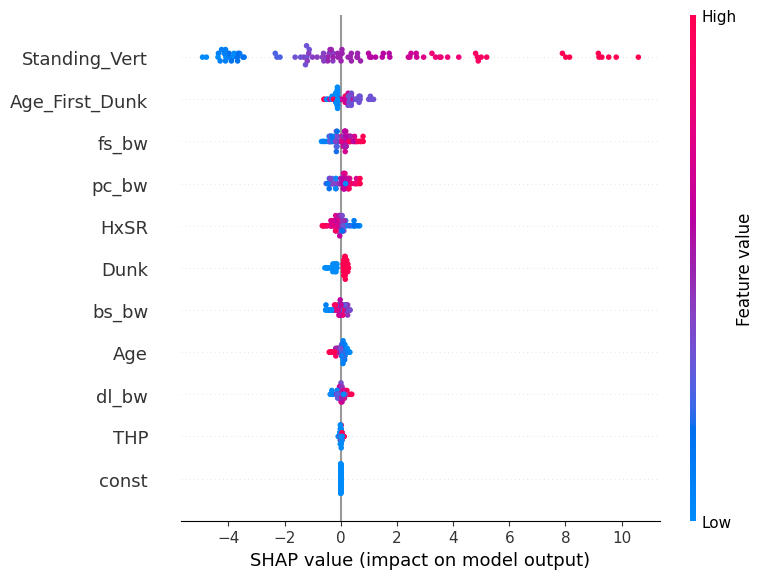

In [44]:
# SHAP Analysis
explainer = shap.Explainer(rf)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


In [45]:
# Train Neural Network
model_nn = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)  # Output Layer
])

model_nn.compile(optimizer="adam", loss="mse", metrics=["mae"])
model_nn.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=16, verbose=1)
y_pred_nn = model_nn.predict(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1233.3364 - mae: 34.8409 - val_loss: 1271.3181 - val_mae: 35.3612
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1196.7415 - mae: 34.2729 - val_loss: 1209.5981 - val_mae: 34.5004
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1145.7953 - mae: 33.5265 - val_loss: 1123.6825 - val_mae: 33.2540
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1069.6044 - mae: 32.4408 - val_loss: 1000.1414 - val_mae: 31.3587
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 931.0999 - mae: 30.2073 - val_loss: 829.2380 - val_mae: 28.5162
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 740.4290 - mae: 26.9042 - val_loss: 614.6808 - val_mae: 24.4520
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 533.2109 - mae: 22.6663 - val_loss: 383.0401 - val_mae: 19.0294
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 333.4045 - mae: 17.4746 - val_loss: 186.9854 - val_mae: 12.6151
Epoch

In [46]:
# Model Evaluation
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R² Score: {r2_score(y_true, y_pred):.2f}\n")

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_gb, "Gradient Boosting")
evaluate_model(y_test, y_pred_nn, "Neural Network")

Model: Random Forest
MSE: 6.40
RMSE: 2.53
R² Score: 0.71

Model: Gradient Boosting
MSE: 6.50
RMSE: 2.55
R² Score: 0.70

Model: Neural Network
MSE: 6.08
RMSE: 2.47
R² Score: 0.72



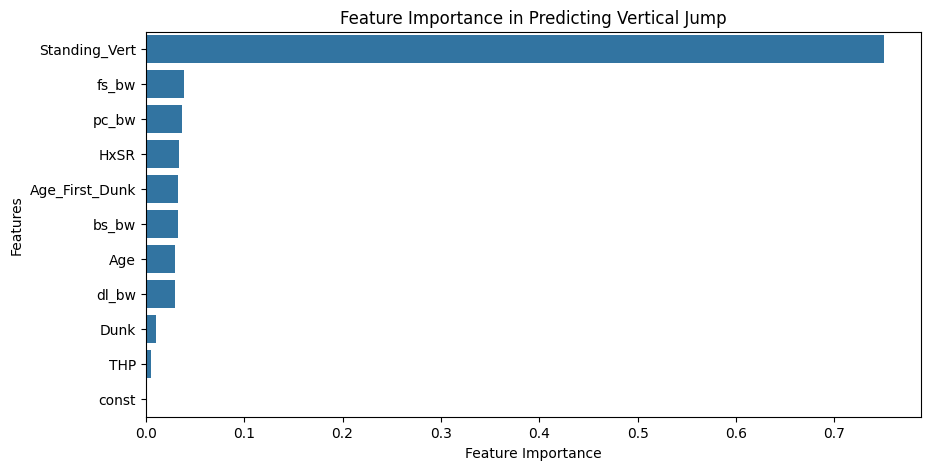

In [47]:
# Feature Importance from Random Forest
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Predicting Vertical Jump")
plt.show()

This makes sense as standing jumps are the most specifc to max approach jumps.

In [48]:
# Bonferroni Coefficient Calculation
alpha = 0.1
n = df1.shape[0]
p = len(scale_cols) + 2
prob = 1 - (alpha / (2 * n))
df_resid = n - p - 1
Bcoef = t.ppf(prob, df_resid)
print(f"Bonferroni Coefficient: {Bcoef}")

Bonferroni Coefficient: 3.642398199423715


In [49]:
# Detecting Outliers
influence = model.get_influence()
df1["RStudent"] = influence.resid_studentized_external
df1["HatDiagonal"] = influence.hat_matrix_diag
df1["DFFITS"] = influence.dffits[0]
df1["CooksD"] = influence.cooks_distance[0]

y_outliers = df1[abs(df1["RStudent"]) > 3.64]
x_outliers = df1[df1["HatDiagonal"] > 0.07]
influential = df1[(abs(df1["DFFITS"]) > 0.37) | (df1["CooksD"] > 0.07)]

print("Y Outliers:")
print(y_outliers)
print("X Outliers:")
print(x_outliers)
print("Influential Points:")
print(influential)

Y Outliers:
     Age  Dunk  Age_First_Dunk  Max_Vert  Standing_Vert  THP     bs_bw  \
275   21     1               1        50             35    1  1.689189   
310   17     1               1        33             35    0  1.852941   

        fs_bw     pc_bw     dl_bw  HxSR  RStudent  HatDiagonal    DFFITS  \
275  1.418919  1.238739  2.027027  7524  4.264603     0.028153  0.725847   
310  1.323529  1.088235  2.382353  6745 -3.680322     0.023325 -0.568751   

       CooksD  
275  0.045333  
310  0.028242  
X Outliers:
     Age  Dunk  Age_First_Dunk  Max_Vert  Standing_Vert  THP     bs_bw  \
33    21     1               3        40             34    1  1.000000   
60    18     1               2        33             30    0  1.740506   
112   33     0               0        28             19    1  2.330986   
127   31     1               4        36             33    1  2.593750   
138   26     0               0        36             33    0  2.919075   
175   41     0               0  

In [50]:
# Train-Test Split
df1["Selected"] = np.random.rand(len(df1)) < 0.7
train = df1[df1["Selected"]].drop(columns=["Selected"])
test = df1[~df1["Selected"]].drop(columns=["Selected"])

In [51]:
# Standardizing train/test
df_train_scaled = train.copy()
df_test_scaled = test.copy()
df_train_scaled[scale_cols] = scaler.fit_transform(train[scale_cols])
df_test_scaled[scale_cols] = scaler.transform(test[scale_cols])

In [52]:
# Train Regression Model
X_train = df_train_scaled[["HxSR", "Dunk", "Age_First_Dunk", "fs_bw", "pc_bw", "dl_bw"]]
X_train = sm.add_constant(X_train)
y_train = df_train_scaled["Max_Vert"]
final_model = sm.OLS(y_train, X_train).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Max_Vert   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     40.29
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           2.39e-33
Time:                        14:20:27   Log-Likelihood:                -625.08
No. Observations:                 237   AIC:                             1264.
Df Residuals:                     230   BIC:                             1288.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             30.5183      0.561     54.

In [53]:
# Predict on Test Data
X_test = df_test_scaled[["HxSR", "Dunk", "Age_First_Dunk", "fs_bw", "pc_bw", "dl_bw"]]
X_test = sm.add_constant(X_test)
y_test = df_test_scaled["Max_Vert"]
predictions = final_model.predict(X_test)

In [54]:
# Model Performance on Test Data
residuals = y_test - predictions
MSE = np.mean(residuals ** 2)
RMSE = np.sqrt(MSE)
print(f"MSE: {MSE}, RMSE: {RMSE}")

MSE: 9.356771259232033, RMSE: 3.0588839891751425


RMSE performed much better. I'd rather have a 3.05 vertical jump difference than a 9.36 veretical jump difference.

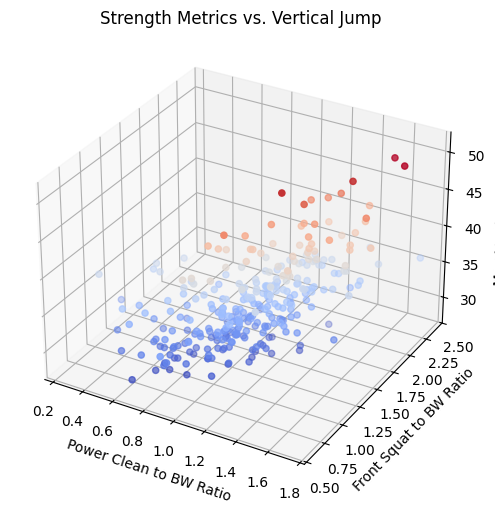

In [55]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df1["pc_bw"], df1["fs_bw"], df1["Max_Vert"], c=df1["Max_Vert"], cmap="coolwarm")
ax.set_xlabel("Power Clean to BW Ratio")
ax.set_ylabel("Front Squat to BW Ratio")
ax.set_zlabel("Max Vertical Jump")
plt.title("Strength Metrics vs. Vertical Jump")
plt.show()